In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

# Connect to GCP

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    project_id = "project-id"
    os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
except:
    pass

## Bronze Layer

In [5]:
### Ingesting data from Google Cloud Storage
bucket_name = "cs611_mle"
transactions_path_in_bucket = "Data Source/transactions.csv"
transactions_gcs_path = f"gs://{bucket_name}/{transactions_path_in_bucket}"

df_transactions = pd.read_csv(transactions_gcs_path)

In [6]:
print(f"transactions.shape: {df_transactions.shape}")

transactions.shape: (3406383, 10)


In [7]:
print("---------------transactions.information---------------")
print(df_transactions.info())

---------------transactions.information---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406383 entries, 0 to 3406382
Data columns (total 10 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Unnamed: 0              int64 
 1   msno                    object
 2   payment_method_id       int64 
 3   payment_plan_days       int64 
 4   plan_list_price         int64 
 5   actual_amount_paid      int64 
 6   is_auto_renew           int64 
 7   transaction_date        int64 
 8   membership_expire_date  int64 
 9   is_cancel               int64 
dtypes: int64(9), object(1)
memory usage: 259.9+ MB
None


In [ ]:
# Create bronze tables and store to Google Cloud Storage
bronze_transactions_file_path = "Bronze Layer/bronze_transactions.csv"
bronze_transactions_gcs_path = f"gs://{bucket_name}/{bronze_transactions_file_path}"

try:
    df_transactions.to_csv(bronze_transactions_gcs_path, index=False)
    print("bronze_transactions.csv Stored to Bronze Layer Successfully! ✅")
except Exception as e:
    print(f"bronze_transactions.csv Store Failed: {e}")

## Silver Layer

To determine a user is churn or not, it should be based on transaction details. Therefore, in label engineering, only transaction.csv will be processed by medallion architecture. Other tables will be proceesed in feature engineering.

In [8]:
df_transactions = df_transactions.iloc[:,1:]
df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'], format='%Y%m%d')
df_transactions['membership_expire_date'] = pd.to_datetime(df_transactions['membership_expire_date'], format='%Y%m%d')
df_transactions = df_transactions.sort_values(by=['msno', 'transaction_date', 'membership_expire_date'])
df_transactions

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1245059,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
3046991,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
1946519,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
504358,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
3159282,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,149,1,2015-05-04,2015-06-04,1
...,...,...,...,...,...,...,...,...,...
734725,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-11-30,2017-01-24,0
277316,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-12-31,2017-02-24,0
298762,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-01-31,2017-03-24,0
3398488,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,2017-04-24,0


In [9]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3406383 entries, 1245059 to 3257080
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   payment_method_id       int64         
 2   payment_plan_days       int64         
 3   plan_list_price         int64         
 4   actual_amount_paid      int64         
 5   is_auto_renew           int64         
 6   transaction_date        datetime64[ns]
 7   membership_expire_date  datetime64[ns]
 8   is_cancel               int64         
dtypes: datetime64[ns](2), int64(6), object(1)
memory usage: 259.9+ MB


In [10]:
df_transactions.isna().sum()

,0
msno,0
payment_method_id,0
payment_plan_days,0
plan_list_price,0
actual_amount_paid,0
is_auto_renew,0
transaction_date,0
membership_expire_date,0
is_cancel,0


In [11]:
df_transactions.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,3.406383e+06,3.406383e+06,3.406383e+06,3.406383e+06,3.406383e+06,3406383,3406383,3.406383e+06
mean,3.939665e+01,3.155030e+01,1.446823e+02,1.473133e+02,9.215306e-01,2016-02-27 22:07:30.980878336,2016-04-16 20:53:10.746314496,5.578380e-02
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015-01-01 00:00:00,1970-01-01 00:00:00,0.000000e+00
25%,3.900000e+01,3.000000e+01,1.290000e+02,1.290000e+02,1.000000e+00,2015-08-07 00:00:00,2015-09-27 00:00:00,0.000000e+00
50%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2016-02-28 00:00:00,2016-04-23 00:00:00,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2016-09-27 00:00:00,2016-11-10 00:00:00,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2017-03-31 00:00:00,2023-08-17 00:00:00,1.000000e+00
std,3.097484e+00,2.936009e+01,1.253914e+02,1.246733e+02,2.689089e-01,NaN,NaN,2.295038e-01


In [12]:
daily_transactions_by_user = df_transactions.groupby(['msno', 'transaction_date', 'is_cancel']).size().reset_index(name='transaction_count')
daily_transactions_by_user = daily_transactions_by_user.sort_values(by = 'transaction_count', ascending = False)
daily_user_counts_by_transactions = daily_transactions_by_user.groupby(['transaction_count']).size().reset_index(name = 'counts')
daily_user_counts_by_transactions['cumsum'] = daily_user_counts_by_transactions['counts'].cumsum()
daily_user_counts_by_transactions['proportion'] = daily_user_counts_by_transactions['cumsum']/daily_user_counts_by_transactions['counts'].sum()
daily_user_counts_by_transactions

,transaction_count,counts,cumsum,proportion
0,1,3349080,3349080,0.991825
1,2,26563,3375643,0.999692
2,3,758,3376401,0.999916
3,4,148,3376549,0.999960
4,5,44,3376593,0.999973
5,6,31,3376624,0.999983
6,7,8,3376632,0.999985
7,8,9,3376641,0.999988
8,9,5,3376646,0.999989
9,10,6,3376652,0.999991


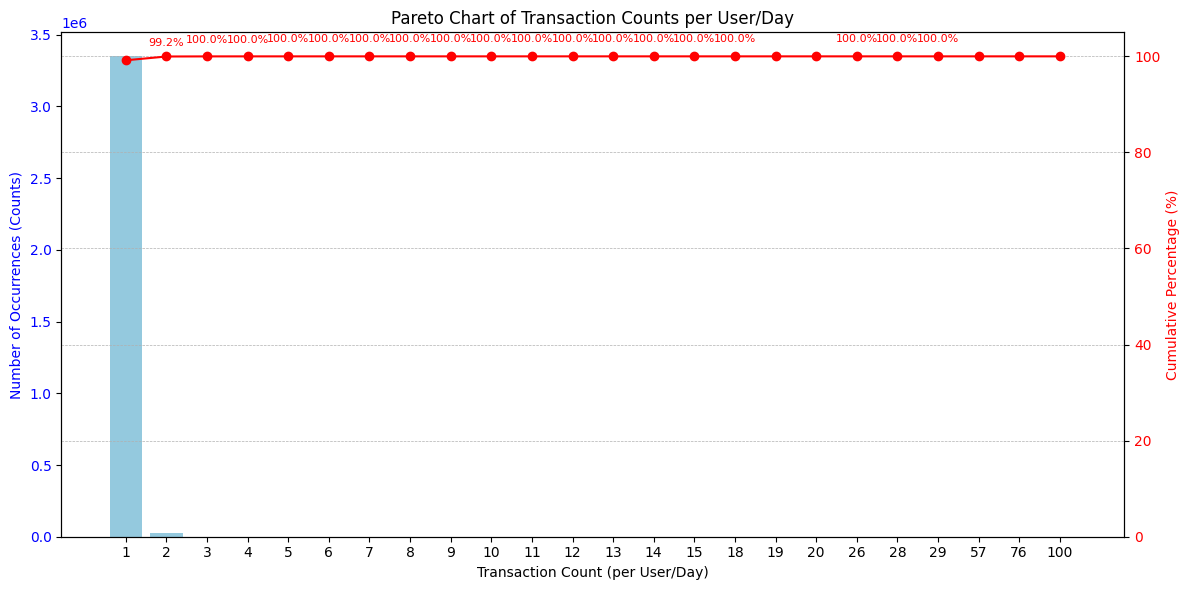

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x='transaction_count', y='counts', data=daily_user_counts_by_transactions, ax=ax1, color='skyblue')
ax1.set_xlabel('Transaction Count (per User/Day)')
ax1.set_ylabel('Number of Occurrences (Counts)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Pareto Chart of Transaction Counts per User/Day')

ax2 = ax1.twinx()
ax2.plot(daily_user_counts_by_transactions['transaction_count'].astype(str),
         daily_user_counts_by_transactions['proportion'] * 100,
         color='red', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105)

for index, row in daily_user_counts_by_transactions.iterrows():
    ax2.annotate(f'{row["proportion"]:.1%}',
                 (row['transaction_count'], row['proportion'] * 100),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [14]:
outlier_user_list = list(daily_transactions_by_user[daily_transactions_by_user['transaction_count'] > 2]['msno'].unique())
filtering = lambda x: True if x not in outlier_user_list else False
df_transactions['filtered'] = df_transactions['msno'].apply(filtering)

In [15]:
# Check proportions of records of "outlier" users
df_transactions[df_transactions['filtered'] == False].shape[0] / df_transactions.shape[0]

0.004605765118015208

In [16]:
df_transactions = df_transactions[df_transactions['filtered'] == True]
df_transactions = df_transactions.drop(columns=['filtered'])
df_transactions

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1245059,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
3046991,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
1946519,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
504358,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
3159282,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,149,1,2015-05-04,2015-06-04,1
...,...,...,...,...,...,...,...,...,...
734725,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-11-30,2017-01-24,0
277316,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-12-31,2017-02-24,0
298762,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-01-31,2017-03-24,0
3398488,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,2017-04-24,0


In [17]:
df_transactions = df_transactions[df_transactions['membership_expire_date'] >= '2015-01-01']
df_transactions

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1245059,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
3046991,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
1946519,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
504358,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
3159282,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,149,1,2015-05-04,2015-06-04,1
...,...,...,...,...,...,...,...,...,...
734725,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-11-30,2017-01-24,0
277316,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-12-31,2017-02-24,0
298762,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-01-31,2017-03-24,0
3398488,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,2017-04-24,0


In [21]:
df_transactions = df_transactions.reset_index(drop=True)

In [22]:
# Create silver table and store to Google Cloud Storage
siver_transactions_file_path = "Silver Layer/silver_transactions.csv"
silver_transactions_gcs_path = f"gs://{bucket_name}/{siver_transactions_file_path}"

try:
    df_transactions.to_csv(silver_transactions_gcs_path, index=False)
    print("silver_transactions.csv Stored to Silver Layer Successfully! ✅")
except Exception as e:
    print(f"silver_transactions.csv Store Failed: {e}")

silver_transactions.csv Stored to Silver Layer Successfully! ✅


## Gold Layer

In [23]:
grace_period = pd.Timedelta(days=10)
label_rows = []

grouped = df_transactions.groupby('msno', sort=False)

for msno, group in tqdm(grouped, total=len(grouped)):
    group = group.reset_index(drop=True)

    for i in range(len(group)):
        row = group.iloc[i]
        expire_date = row['membership_expire_date']

        if 30 <= row['payment_plan_days'] <= 31 and row['is_cancel'] == 0:
            found = False

            for j in range(i + 1, len(group)):
                next_row = group.iloc[j]

                if next_row['transaction_date'] > expire_date + grace_period:
                    break

                if next_row['transaction_date'] <= expire_date + grace_period and next_row['is_cancel'] == 0:
                    found = True
                    break

            churn = 0 if found else 1
            membership_start_date = expire_date - pd.to_timedelta(row['payment_plan_days'], unit='D')

            label_rows.append({
                "msno": row["msno"],
                "membership_start_date": membership_start_date,
                "membership_expire_date": expire_date,
                "churn": churn
            })

df_labels = pd.DataFrame(label_rows)

100%|██████████| 188874/188874 [13:16<00:00, 237.21it/s]


In [24]:
df_labels.head()

,msno,membership_start_date,membership_expire_date,churn
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-01-10,2015-02-09,0
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-02-07,2015-03-09,0
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-03-10,2015-04-09,0
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-04-09,2015-05-09,0
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-07-04,0


Proportion of 0s: 0.917
Proportion of 1s: 0.083


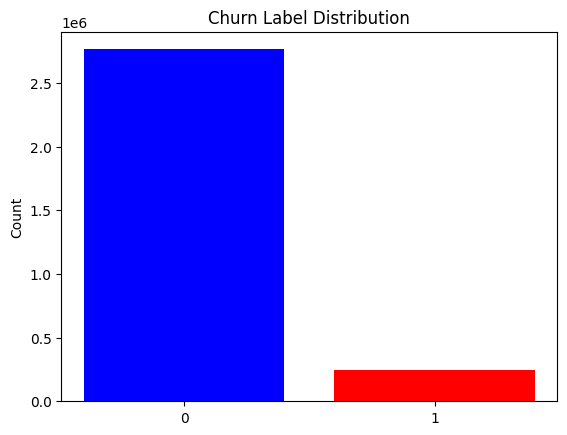

In [29]:
churn_counts = df_labels['churn'].value_counts().sort_index()
churn_proportions = df_labels['churn'].value_counts(normalize=True).sort_index()

print(f"Proportion of 0s: {churn_proportions.iloc[0]:.3f}")
print(f"Proportion of 1s: {churn_proportions.iloc[1]:.3f}")

plt.bar(churn_counts.index, churn_counts.values, color=['blue', 'red'])
plt.ylabel('Count')
plt.xticks([0, 1])
plt.title('Churn Label Distribution')
plt.show()

In [32]:
# Create gold table and store to Google Cloud Storage
gold_label_file_path = "Gold Layer/labels.csv"
gold_label_gcs_path = f"gs://{bucket_name}/{gold_label_file_path}"

try:
    df_labels.to_csv(gold_label_gcs_path, index=False)
    print("labels.csv Stored to Gold Layer Successfully! ✅")
except Exception as e:
    print(f"labels.csv Store Failed: {e}")

labels.csv Stored to Gold Layer Successfully! ✅
